In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import End2EndSim

In [3]:
CONFIG = {
    'gal_type': 'exp',
    'psf_type': 'gauss',
    'shear_scene': True,
    'n_coadd': 10,
    'scale': 0.263,
    'n_bands': 3,
    'position_angle_range': (0, 360),
    'scale_frac_std': 0.03,
    'wcs_shear_std': 0.03,
    'wcs_dither_range': (-0.5, 0.5),
    'psf_kws': {'fwhm_frac_std': 0.1, 'shear_std': 0.03}
}

sim = End2EndSim(
    rng=np.random.RandomState(seed=42),
    **CONFIG,
    g1=0.02)

In [4]:
%%time

mbobs, ims = sim.get_mbobs(return_band_images=True)

CPU times: user 8.43 s, sys: 281 ms, total: 8.72 s
Wall time: 8.67 s


galsim.Shear(g1=0.019216165049450225,g2=-0.004177955124708715) 0.8895806438096893


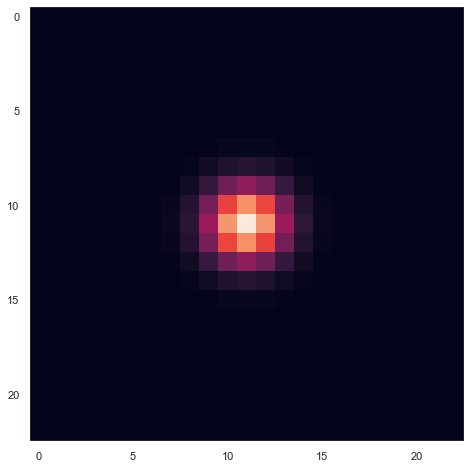

In [6]:
band = 0

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.imshow(np.arcsinh(mbobs[band][0].psf.image[26-11:26+12, 26-11:26+12]))
ax.grid(False)

from galsim.hsm import FindAdaptiveMom

psf_im = galsim.ImageD(mbobs[band][0].psf.image, scale=sim.scale)
admom = FindAdaptiveMom(psf_im)
print(admom.observed_shape, psf_im.calculateFWHM())

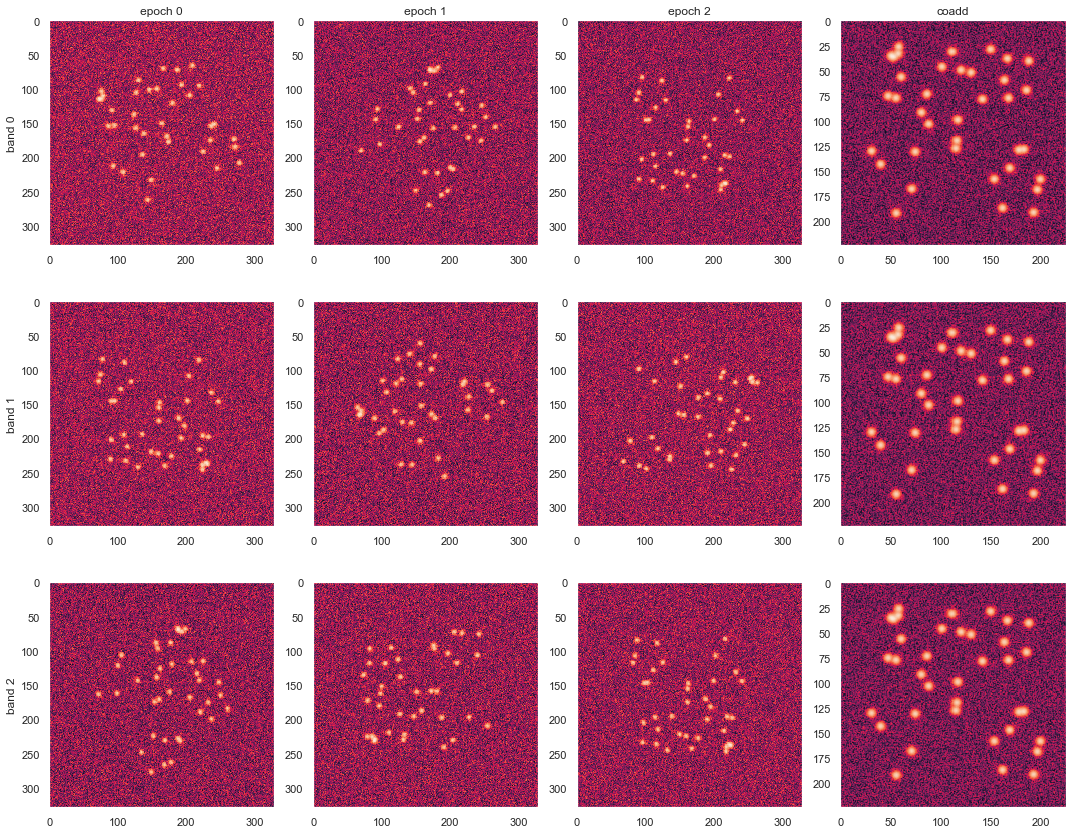

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))

for band in range(3):
    for epoch in range(3):
        ax = axs[band, epoch]
        ax.imshow(np.arcsinh(ims[band][epoch]/sim.noise[band]))
        ax.grid(False)
        
        if epoch == 0:
            ax.set_ylabel('band %d' % band)
        
        if band == 0:
            ax.set_title('epoch %d' % epoch)
    
    ax = axs[band][3]
    ax.imshow(np.arcsinh(mbobs[band][0].image / np.std(mbobs[band][0].noise)))
    ax.grid(False)

    if band == 0:
        ax.set_title('coadd')


plt.tight_layout()
plt.show()

In [3]:
from scipy.interpolate import approximate_taylor_polynomial, pade

In [184]:
order = 20
porder = order // 2

t = approximate_taylor_polynomial(lambda x: np.sinc(x)/(x-1)/(x-2)/(x-3), 0, order, 3.01, order=order+8)

p, q = pade(t.coefficients[::-1], porder)

def sinc_pade(x):
    return p(x) / q(x) * (x-1) * (x-2) * (x-3)

0 0.9999999999999936
1 -0.0
2 0.0
3 0.0
6.893491494124049e-08


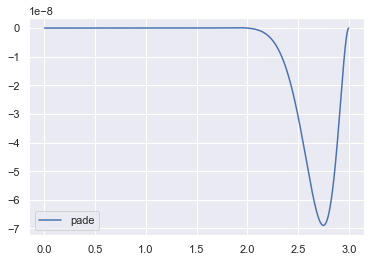

In [185]:
al = 3
x = np.linspace(0, al, 10000)

plt.figure()
if False:
    plt.plot(x, np.sinc(x) * np.sinc(x/al), label='true')
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al), label='pade')
else:
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al), label='pade')
plt.legend()

for _x in [0, 1, 2, 3]:
    print(_x, sinc_pade(_x) * sinc_pade(_x/al))

print(np.max(np.abs(sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al))))

In [171]:
from numba import njit

In [172]:
def _make_code(poly):
    d = []
    for p, c in enumerate(poly.coef[::-1]):
        d.append('%0.15g + x * (' % (c))

    print('\n'.join(d))

In [173]:
_make_code(p)
_make_code(q)

-0.166666666666666 + x * (
-0.289176685343373 + x * (
-0.109757669089546 + x * (
0.0350931080575596 + x * (
0.0229947584643336 + x * (
-0.00089363958201935 + x * (
-0.00162722192965722 + x * (
-3.00689146075626e-05 + x * (
5.13864469774294e-05 + x * (
1.23561563382214e-06 + x * (
-6.37392253619041e-07 + x * (
1 + x * (
-0.0982732212730775 + x * (
0.122536542608403 + x * (
-0.0111525324680647 + x * (
0.00724707512833019 + x * (
-0.000584774445653404 + x * (
0.000262528048296579 + x * (
-1.71596576734417e-05 + x * (
5.91945411660804e-06 + x * (
-2.44174818579491e-07 + x * (
6.74473938075399e-08 + x * (


In [174]:
@njit
def sinc_pade(x):
    x = np.abs(x)

    num = (  # noqa
        -0.166666666666666 + x * (
        -0.289176685343373 + x * (
        -0.109757669089546 + x * (
        0.0350931080575596 + x * (
        0.0229947584643336 + x * (
        -0.00089363958201935 + x * (
        -0.00162722192965722 + x * (
        -3.00689146075626e-05 + x * (
        5.13864469774294e-05 + x * (
        1.23561563382214e-06 + x * (
        -6.37392253619041e-07))))))))))) * (x-1) * (x-2) * (x-3)
    den = (  # noqa
        1 + x * (
        -0.0982732212730775 + x * (
        0.122536542608403 + x * (
        -0.0111525324680647 + x * (
        0.00724707512833019 + x * (
        -0.000584774445653404 + x * (
        0.000262528048296579 + x * (
        -1.71596576734417e-05 + x * (
        5.91945411660804e-06 + x * (
        -2.44174818579491e-07 + x * (
        6.74473938075399e-08)))))))))))
    return num / den

@njit
def sinc(x):
    return np.sinc(x)

0 0.999999999999992
1 -0.0
2 0.0
3 0.0
6.893490387890888e-08


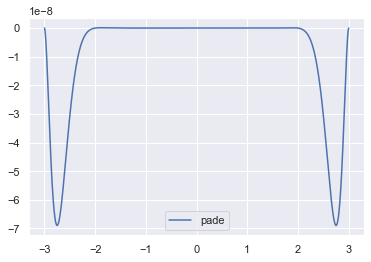

In [175]:
al = 3
x = np.linspace(-al, al, 10000)

plt.figure()
if False:
    plt.plot(x, np.sinc(x) * np.sinc(x/al), label='true')
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al), label='pade')
else:
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al), label='pade')
plt.legend()

for _x in [0, 1, 2, 3]:
    print(_x, sinc_pade(_x) * sinc_pade(_x/al))
    
print(np.max(np.abs(sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al))))

In [176]:
%%timeit

sinc(x) * sinc(x/al)

478 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [178]:
%%timeit

sinc_pade(x) * sinc_pade(x/al)

219 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
